# Classifying Spotify Songs

The dataset for this project features a comprehensive collection of 2023's most popular songs, as described in this [GitHub Repository](https://github.com/jivanjotk/Most-Streamed-Spotify-Songs-2023-Analysis-). Beyond basic information, the dataset provides detailed insights into each song's characteristics, popularity, and a variety of audio attributes.

The goal of this notebook is to predict whether a song will make it onto a Spotify chart, based on its audio and popularity features.

**Key Features of the Dataset:**

- **track_id:** Unique identifier for each song
- **artist_count:** Number of artists contributing to the song
- **spotify_chart:** Song's rank and presence on Spotify charts
- **bpm:** Beats per minute, indicating the tempo
- **key:** Musical key of the song
- **mode:** Indicates whether the song is in a major or minor mode
- **danceability:** Score reflecting how suitable the song is for dancing
- **valence:** Measure of the song's musical positivity
- **energy:** Perceived energy level of the track
- **acousticness:** Degree of acoustic elements present
- **instrumentalness:** Amount of instrumental content in the song
- **liveness:** Measure of live performance characteristics
- **speechiness:** Proportion of spoken words in the track


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

## Data

In [4]:
# Read data
path_data = "https://github.com/pabloestradac/causalml-basics/raw/main/data/"
df = pd.read_csv(path_data + 'spotify-2023.csv')
df = df.loc[:, ['track_id', 'spotify_chart', 'artist_count', 'bpm', 'key', 'mode', 'danceability',
                'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']]
df['top'] = np.where(df['spotify_chart'] > 0, 1, 0)
df = df.dropna(ignore_index=True)
df.tail()

,track_id,spotify_chart,artist_count,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,top
853,948,0,1,144,A,Major,60,24,39,57,0,8,3,0
854,949,0,1,166,F#,Major,42,7,24,83,1,12,6,0
855,950,0,2,92,C#,Major,80,81,67,4,0,8,6,0
856,951,0,3,97,C#,Major,82,67,77,8,0,12,5,0
857,952,2,1,90,E,Minor,61,32,67,15,0,11,5,1


In [5]:
# Inspect the data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   track_id          858 non-null    int64 
 1   spotify_chart     858 non-null    int64 
 2   artist_count      858 non-null    int64 
 3   bpm               858 non-null    int64 
 4   key               858 non-null    object
 5   mode              858 non-null    object
 6   danceability      858 non-null    int64 
 7   valence           858 non-null    int64 
 8   energy            858 non-null    int64 
 9   acousticness      858 non-null    int64 
 10  instrumentalness  858 non-null    int64 
 11  liveness          858 non-null    int64 
 12  speechiness       858 non-null    int64 
 13  top               858 non-null    int64 
dtypes: int64(12), object(2)
memory usage: 94.0+ KB


,track_id,spotify_chart,artist_count,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,top
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,476.088578,11.945221,1.551282,122.827506,67.256410,51.247086,64.344988,26.621212,1.609557,18.173660,10.388112,0.574592
std,275.962906,19.187353,0.864335,28.183522,14.652712,23.594781,16.047766,25.681877,8.565909,13.561611,10.088162,0.494693
min,0.000000,0.000000,1.000000,65.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000,0.000000
25%,237.250000,0.000000,1.000000,100.000000,57.000000,32.000000,53.250000,5.000000,0.000000,10.000000,4.000000,0.000000
50%,477.000000,3.000000,1.000000,121.000000,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000,1.000000
75%,715.750000,16.000000,2.000000,141.750000,78.000000,70.000000,76.000000,42.000000,0.000000,24.000000,12.000000,1.000000
max,952.000000,147.000000,8.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,1.000000


## Using Statsmodels for Logistic Regression

In logistic regression, the dependent variable is binary, and the goal is to model the probability that the dependent variable belongs to a particular category. In this case, the dependent variable will be a binary variable indicating whether a song made it onto the Spotify chart. This is

$$
P(\text{Spotify Chart} = 1 | X) = \frac{e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}} ,
$$

where $X = (X_1, \ldots, X_p)$ are the predictors, and $\beta = (\beta_0, \ldots, \beta_p)$ are the coefficients.

The `GLM()` function from the `statsmodels` library will be used to perform logistic regression using the class of generalized linear models. Alternatively, the function `Logit()` fits a logistic regression model directly. The syntax of `GLM()` is similar to that of sm.OLS(), except that we must pass in the argument `family=sm.families.Binomial()`.

In [6]:
import patsy

model = ('0 + artist_count + bpm + key + mode '
         '+ danceability + valence + energy + acousticness + instrumentalness + liveness + speechiness')
Xbase = patsy.dmatrix(model, df, return_type='dataframe')
y = df['top']

In [7]:
import statsmodels.api as sm

glm = sm.GLM(y, Xbase, family=sm.families.Binomial())
results = glm.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
key[A],-1.2466,0.717,-1.739,0.082,-2.651,0.158
key[A#],-0.9800,0.730,-1.342,0.180,-2.411,0.451
key[B],-1.0163,0.736,-1.381,0.167,-2.458,0.426
key[C#],-1.2459,0.714,-1.746,0.081,-2.645,0.153
key[D],-1.5276,0.727,-2.102,0.036,-2.952,-0.103
key[D#],-1.6982,0.772,-2.199,0.028,-3.212,-0.185
key[E],-1.2874,0.740,-1.739,0.082,-2.738,0.164
key[F],-0.8496,0.718,-1.184,0.236,-2.256,0.557
key[F#],-0.9611,0.744,-1.293,0.196,-2.418,0.496
key[G],-1.4767,0.714,-2.070,0.038,-2.875,-0.078


## Using Scikit-learn for Logistic Regression

The logistic regression is implemented in `LogisticRegression`. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

This implementation can fit binary, One-vs-Rest, or multinomial logistic regression with optional $\ell_1$, $\ell_2$ or Elastic-Net regularization.

Regularization is applied by default, which is common in machine learning but not in statistics. Another advantage of regularization is that it improves numerical stability. No regularization amounts to setting C to a very high value.

Logistic regression is a special case of Generalized Linear Models (GLM) with a Binomial / Bernoulli conditional distribution and a Logit link. The numerical output of the logistic regression, which is the predicted probability, can be used as a classifier by applying a threshold (by default 0.5) to it. This is how it is implemented in scikit-learn, so it expects a categorical target, making the Logistic Regression a classifier.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xbase, y, test_size=0.3, random_state=42)

# Fit the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions with train data
y_pred = clf.predict(X_train)

# Evaluate the model with train data
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.37      0.45       260
           1       0.62      0.81      0.71       340

    accuracy                           0.62       600
   macro avg       0.61      0.59      0.58       600
weighted avg       0.61      0.62      0.60       600



- Precision measures the proportion of positive identifications that were actually correct. It is given by $\text{TP} / (\text{TP} + \text{FP})$, where TP is the number of true positives and FP is the number of false positives. So if precision is 0.6, then 60% of the songs that the model predicted to be on the Spotify chart were actually on the chart.
- Recall measures the proportion of actual positives that were identified correctly. It is given by $\text{TP} / (\text{TP} + \text{FN})$, where FN is the number of false negatives. So if recall is 0.7, then 70% of the songs that were actually on the Spotify chart were correctly identified by the model.
- The F1 score is the harmonic mean of precision and recall, and is given by $2 \times \text{Precision} \times \text{Recall} / (\text{Precision} + \text{Recall})$. So, if your F1 Score is high, it means your model has found a good balance between precision and recall.
- Accuracy measures the proportion of true results (both true positives and true negatives) in the population. It is given by $(\text{TP} + \text{TN}) / (\text{TP} + \text{TN} + \text{FP} + \text{FN})$. So if accuracy is 0.8, then 80% of the songs were correctly classified by the model.
- Macro-average calculates the metric independently for each class and then takes the average (hence treating all classes equally), whereas micro-average aggregates the contributions of all classes to compute the average metric.

In [10]:
# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.31      0.39       105
           1       0.62      0.78      0.70       153

    accuracy                           0.59       258
   macro avg       0.56      0.55      0.54       258
weighted avg       0.57      0.59      0.57       258



As we have seen previously, the training error rate is often overly optimistic — it tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data.

In [11]:
# Confusion matrix
confusion_matrix(y_test, y_pred) 

array([[ 33,  72],
       [ 33, 120]])

In the confusion matrix, each row represents the actual class, while each column represents the predicted class.

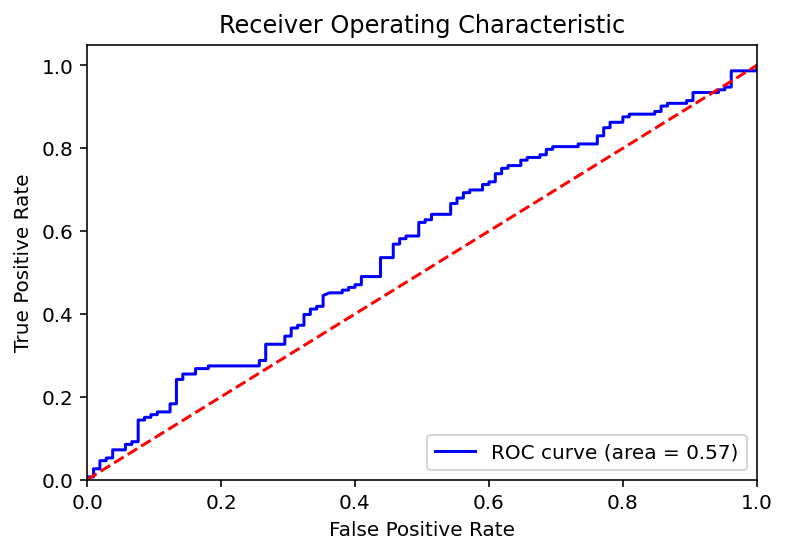

In [12]:
# ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show() 


The ROC curve is drawn by calculating the true positive rate (TPR) and false positive rate (FPR) at every possible threshold (in practice, at selected intervals), then graphing TPR over FPR. 

The area under the ROC curve (AUC) is a measure of the accuracy of the model. AUC represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative. An AUC of 0.5 indicates that the model is no better than random, while an AUC of 1 indicates that the model is perfect.

## Linear Discriminant Analysis



In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit the model
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.31      0.38       105
           1       0.62      0.76      0.68       153

    accuracy                           0.58       258
   macro avg       0.54      0.54      0.53       258
weighted avg       0.56      0.58      0.56       258



In [12]:
# Confusion matrix
confusion_matrix(y_test, y_pred) 

array([[ 33,  72],
       [ 37, 116]])

## K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Fit KNN model
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.34      0.38       105
           1       0.60      0.69      0.64       153

    accuracy                           0.55       258
   macro avg       0.52      0.51      0.51       258
weighted avg       0.53      0.55      0.54       258



In [14]:
# Tuning KNN model
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

# Best parameters
print("Best parameters for KNN:", knn_cv.best_params_['n_neighbors'])
print("Best cross-validation score for KNN:", round(knn_cv.best_score_, 2))

# Make predictions with the best KNN model
y_pred = knn_cv.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

Best parameters for KNN: 15
Best cross-validation score for KNN: 0.58
              precision    recall  f1-score   support

           0       0.47      0.27      0.34       105
           1       0.61      0.80      0.69       153

    accuracy                           0.58       258
   macro avg       0.54      0.53      0.52       258
weighted avg       0.56      0.58      0.55       258



## Support Vector Machines

In [15]:
# Fit Support Vector Machine model
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(X_train, y_train)

# Make predictions with test data
y_pred = clf.predict(X_test)

# Evaluate the model with test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       105
           1       0.59      0.98      0.74       153

    accuracy                           0.59       258
   macro avg       0.50      0.50      0.39       258
weighted avg       0.51      0.59      0.45       258



In [ ]:
# Confusion matrix
confusion_matrix(y_test, y_pred) 